# Машинное обучение, DS-поток
## Задание 1.1


**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Теоретические задачи необходимо оформить в LaTeX/markdown или же прислать фотку в правильной ориентации рукописного решения, **где все четко видно**.
* При решении без доказательства можно пользоваться любыми теоретическими свойствами, которые были на лекциях или семинарах.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.

**Баллы за задание**
* Задача 1 &mdash; 2 балла
* Задача 2 &mdash; 2 балла
* Задача 3 &mdash; 12 баллов
* Задача 4 &mdash; 3 балла

## Задача 1.

Докажите, что критерий Джини равен вероятности ошибки случайного классификатора, который выдаёт предсказания с вероятностями пропорционально доле классов в выборке. 

## Задача 2.

Пусть $X = (x_1, ..., x_n)$ &mdash; выборка объектов и $Y = (Y_1, ..., Y_n)$ &mdash; соответствующие значения вещественного отклика. Критерий информативности для набора объектов вычисляется на основе того, насколько хорошо их отклик предсказывается константой:

$$
H(X) = \min_{c \in Y} \dfrac{1}{n} \sum_{i=1}^n L(Y_i, c),
$$

где $L(y, c)$ &mdash; некоторая функция потерь. Соответственно, чтобы получить вид критерия при конкретной функции потерь, необходимо аналитически найти оптимальное значение константы и подставить его в формулу для $H(X)$.

Выведите критерии информативности для следующих функций потерь:
1. $L(y, c) = (y-c)^2$;
2. $L(y, c) = |y-c|$.

Найдите также оптимальное предсказание в листьях дерева.

## Задача 3.

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.metrics import f1_score, make_scorer

warnings.filterwarnings('ignore')
sns.set(font_scale=1.6)
plt.rcParams['axes.facecolor'] = 'lightgrey'

Вспомним, как именно происходит построение решающего дерева. Для построения дерева в каждой нелистовой вершине происходит разбиение подвыборки на две части по некоторому признаку $x_j$. Этот признак и порог $t$, по которому будет происходить разбиение, мы хотим брать не произвольно, а основываясь на соображениях оптимальности.  Для этого нам необходимо знать некоторый фукционал качества, который будем оптимизировать при построении разбиения. 

Обозначим через $X_m$ — множество объектов, попавших в вершину $m$, разбиваемую на данном шаге, а через $X_l$ и $X_r$ — объекты, попадающие в левое и правое поддерево соответственно при заданном правиле $I\{x_j < t\}$. Пусть также $H$ — используемый критерий информативности (impurity criterion).

Выпишите функционал, который необходимо минимизировать при разбиении вершины:

**Ответ:** $Q(X_m,j,t)=\frac{|X_l|}{|X_m|}\cdot H(X_l)+\frac{|X_r|}{|X_m|}\cdot H(X_r)$

**Реализация критериев информативности.**


Вспомните еще раз, на какой общей идее основаны критерии информативности и какую характеристику выборки они стремятся оптимизировать?

**Ответ:** вообще $H(X)$ показывает насколько хорошо целевые переменные предсказываются константой при оптимальном выборе константы. Также он показывает разброс ответов в одной вершине. И чем меньше разброс ответов, то тем и меньше будет значение критерия информативности.


$H(X)=\min\limits_{c\in Y}\frac{1}{|X|}\sum\limits_{x_i\in X}L(Y_i,c),$ где $L(Y,c)$- некоторая функция потерь.

Перед тем, как непосредственно работать с решающими деревьями, реализуйте функции подсчёта значения критериев разбиения вершин решающих деревьев. Использовать готовые реализации критериев или классов для решающих деревьев из `sklearn` и из других библиотек **запрещено.** Также при реализации критериев по причине неэффективности **запрещается использовать циклы**. Воспользуйтесь библиотекой `numpy`.

Каждая функция принимает на вход одномерный `numpy` — массив размерности `(n,)` из значений отклика.

In [2]:
# Код функций, реализующих критерии разбиения. 

def mean_square_criterion(y):
    ''' Критерий для квадратичной функции потерь. '''
    H=1/len(y)*np.sum((y-np.mean(y))**2)
    return H


def mean_abs_criterion(y):
    ''' Критерий для абсолютной функции потерь. '''
    H=1/len(y)*np.sum(np.abs(y-np.median(y)))
    return H


def get_probs_by_y(y):
    ''' Возвращает вектор частот для каждого класса выборки. '''
    n=len(y)
    res=np.unique(y, return_counts=True)[1]
    return res/n


def gini_criterion(y):
    ''' Критерий Джини. '''
    p=get_probs_by_y(y)
    H=np.sum(p*(1-p))
    return H


def entropy_criterion(y):
    ''' Энтропийный критерий. '''
    p=get_probs_by_y(y)
    H=-np.sum(p*np.log(p))
    return H

Протестируйте реализованные функции.

Тесты для распределения вероятностей на классах.

In [3]:
assert np.allclose(get_probs_by_y([1, 1, 2, 2, 7]), np.array([0.4, 0.4, 0.2]))
assert np.allclose(get_probs_by_y([1]), np.array([1]))

Тесты для критериев разбиения.

In [4]:
assert np.allclose(entropy_criterion([25]), 0)
assert np.allclose(gini_criterion([25]), 0)
assert np.allclose(mean_square_criterion([10, 10, 10]), 0)
assert np.allclose(mean_abs_criterion([10, 10, 10]), 0)

**Реализация класса решающего дерева.**

Для того, чтобы лучше понять, как устроены решающие деревья и как именно устроен процесс их построения, вам предлагается реализавать класс `BaseDecisionTree`, реализующий базовые функции решающего дерева.  Большая часть кода уже написана. 

Используются следующие классы:

**Класс** `BaseDecisionTree` — класс для решающего дерева, в котором реализовано построение дерева. Все вершины дерева хранятся в списке `self.nodes`, при этом вершина с номером 0 — корень.


* `__init__` — инициализация дерева. Здесь сохраняются гиперпараметры дерева: `criterion`, `max_depth`, `min_samples_split` и инициализируется список вершин, состоящий только из одной вершины — корневой,
* `build_` — рекурсивная функция построения дерева. В ней при посещении каждой вершины дерева проверяются условия, стоит ли продолжать разбивать эту вершину. Если да, то перебираются все возможные признаки и пороговые значения и выбирается та пара (признак, значение), которой соответствует наименьшее значение критерия информативности,
* `fit` — функция обучения дерева, принимающая на вход обучающую выборку. В этой функции происходит предподсчёт всех возможных пороговых значений для каждого из признаков, а затем вызывается функция `build_`.

**Класс** `Node` — класс вершины дерева. Внутри вершины, помимо раздяляющего признака и порога хранятся `self.left_son`, `self.right_son` — номера дочерних вершин, а также `self.left_prob` и `self.right_prob` — вероятности попадания элемента в каждую из них. При этом в листовых вершиных хранятся также `self.y_values` — значения соответствующих элементов выборки, попавших в вершину.

* `__init__` — инициализация вершины. Принимает в качестве аргументов разделяющий признак и пороговое значение и сохраняет их.

**Класс** `DecisionTreeRegressor` — наследник класса `BaseDecisionTree`, в котором реализованы функции для предсказаний при решении задачи регрессии.

* `predict_instance` — получение предсказания для одного элемента выборки. Выполняется посредством спуска по решающему дереву до листовой вершины,

* `predict` — получение предсказаний для всех элементов выборки.


**Класс** `DecisionTreeClassifier` — наследник класса `BaseDecisionTree`, в котором реализованы функции для предсказаний при решении задачи классификации.
* `predict_proba_instance` — предсказание распределения вероятностей по классам для одного элемента выборки, 
* `predict_proba` — предсказание распределения вероятностей по классам для всех элементов выборки,
* `predict` — предсказание меток классов для всех элементов выборки.

Перед написанием кода разбиения дерева, ответьте на вопрос, какие пороговые значения для каждого из признаков вы будете перебирать. Почему рассматривать другие значения в качестве пороговых не имеет смысла?

**Ответ:** Допустим мы хотим разбить по признаку $j$, тогда пороговые значения равны множеству всех значений j признака элементов, которые находятся в данной вершине. Другие значения нам не надо рассматривать, так как по такому пороговому значению мы и так сможем все элементы разделить на левое и правое поддерево. 

**Структура решающего дерева**


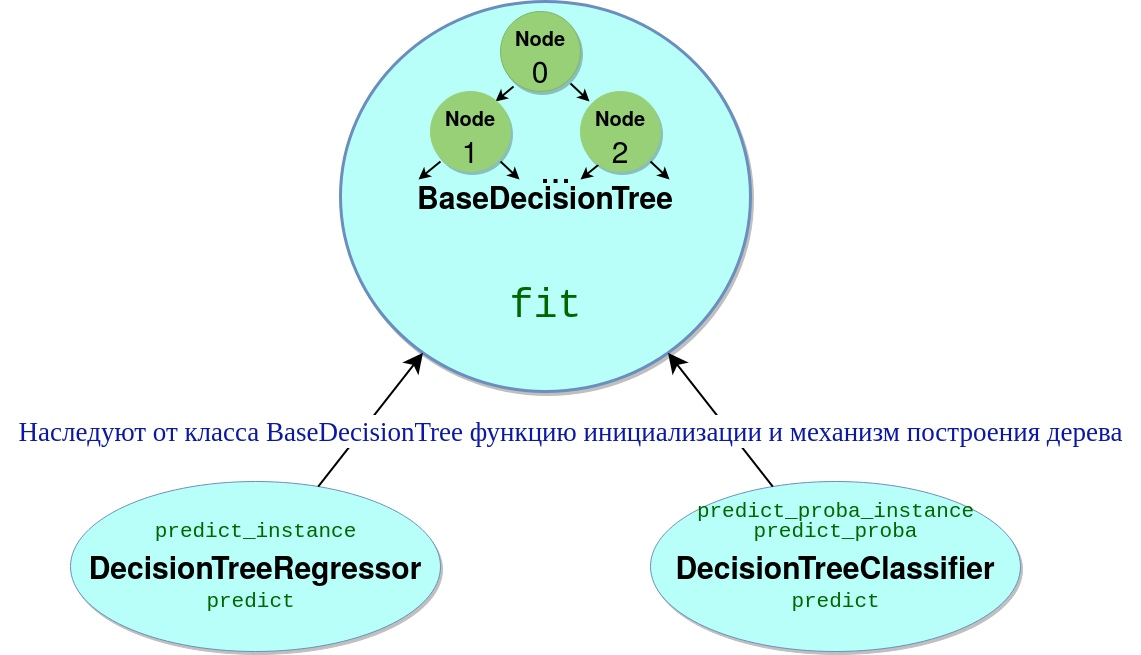

In [5]:
def get_not_nans(arr):
    '''
    Функция, которая создаёт и возвращает новый массив 
    из всех элементов переданного массива, не являющихся None.
    '''
    
    return arr.copy()[~np.isnan(arr)]


class Node(object):
    def __init__(self, split_feature=None, split_threshold=None):
        '''
        Функция инициализации вершины решающего дерева.
        
        Параметры.
        1) split_feature — номер разделяющего признака
        2) split_threshold — пороговое значение
        '''
        
        self.split_feature = split_feature
        self.split_threshold = split_threshold

        # По умолчанию считаем, что у вершины нет дочерних вершин.
        self.left_son, self.right_son = None, None

        # Вероятности попадания в каждую из дочерних вершин нужно поддерживать 
        # для корректной обработки данных с пропусками
        self.left_prob, self.right_prob = 0, 0

        # Массив значений y. Определён только для листовых вершин дерева
        self.y_values = None
        

class BaseDecisionTree(BaseEstimator):
    '''
    Здесь содержится реализация всех основных функций для работы
    с решающим деревом.
    
    Наследование от класса BaseEstimator нужно для того, чтобы 
    в дальнейшем данный   класс можно было использовать в 
    различных функциях библиотеки sklearn, например, в функциях 
    для кросс-валидации.
    '''
    
    def __init__(self, criterion, max_depth=np.inf, min_samples_split=2):
        '''
        Функция инициализации решающего дерева.
        
        Параметры.
        1) criterion — критерий информативности, 
        2) max_depth — максимальная глубина дерева,
        3) min_samples_split — минимальное количество элементов 
        обучающей выборки,  которое должно попасть в вершину, 
        чтобы потом происходило разбиение этой вершины.
        '''
        
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

        # Список всех вершин дерева. В самом начале 
        # работы алгоритма есть только одна 
        # вершина — корень.
        self.nodes = [Node()]

        # Количество классов. Актуально только 
        # при решении задачи классификации.
        self.class_count = 1

        # Сюда нужно будет записать все значения 
        # для каждого из признаков датасета
        # (они будут нашими порогами).
        self.feature_values = None
    
    def build_(self, v, X, y, depth=0):
        '''
        Рекурсивная функция построения решающего дерева.
        
        Параметры.
        1) v — номер рассматриваемой вершины
        2) X, y — обучающая выборка, попавшая в текущую вершину
        3) depth — глубина вершины с номером v
        '''
        if depth == self.max_depth or len(y) < self.min_samples_split:
            # Еcли строим дерево для классификации, то 
            # сохраняем метки классов всех элементов выборки,
            # попавших в вершину.
            if callable(getattr(self, "set_class_count", None)):
                self.nodes[v].y_values = y.copy()

            # Для регрессии сразу вычислим среднее всех 
            # элементов вершины.
            else:
                self.nodes[v].y_values = np.mean(y)
            return
        
        best_criterion_value = np.inf
        best_feature, best_threshold = 0, 0
        sample_size, feature_count = X.shape
        
        # переберём все возможные признаки и значения порогов,
        # найдём оптимальный признак и значение порога 
        # и запишем их в best_feature, best_threshold
        for feature_id in range(feature_count):
            min_feature_id,max_feature_id =np.min(X[:,feature_id]),np.max(X[:,feature_id])
            #еще одна проверка на бамбук, так как в некоторых критериях надо делить на 0 в случае бамбука
            for threshold in self.feature_values[feature_id]:
                if (threshold<=min_feature_id or threshold>max_feature_id):
                    continue
                X_L=X[X[:,feature_id]<threshold]
                X_R=X[X[:,feature_id]>=threshold]
                H_L=self.criterion(y[X[:,feature_id]<threshold])
                H_R=self.criterion(y[X[:,feature_id]>=threshold])
                Q=len(X_L)/sample_size*H_L+len(X_R)/sample_size*H_R
                if Q<best_criterion_value:
                    best_criterion_value=Q
                    best_feature,best_threshold=feature_id,threshold
                
            
        # сохраним найденные параметры в класс текущей вершины
        self.nodes[v].split_feature = best_feature
        self.nodes[v].split_threshold = best_threshold
        # разделим выборку на 2 части по порогу
        X_l=X[X[:,best_feature]<best_threshold]
        X_r=X[X[:,best_feature]>=best_threshold]
        y_l=y[X[:,best_feature]<best_threshold]
        y_r=y[X[:,best_feature]>=best_threshold]
        
        if (len(y_l)==0 or len(y_r)==0 or best_criterion_value==np.inf):#чтобы дерево не начало превращаться в бамбук
             # Еcли строим дерево для классификации, то 
            # сохраняем метки классов всех элементов выборки,
            # попавших в вершину.
            if callable(getattr(self, "set_class_count", None)):
                self.nodes[v].y_values = y.copy()

            # Для регрессии сразу вычислим среднее всех 
            # элементов вершины.
            else:
                self.nodes[v].y_values = np.mean(y)
            return
        
        #print(len(y_l),len(y_r))
        
        #надо не забыть обновить left_prob and right_prob
        self.nodes[v].left_prob=len(X_l)/sample_size
        self.nodes[v].right_prob=len(X_r)/sample_size
        
        # создаём левую и правую дочерние вершины,
        # и кладём их в массив self.nodes 
        self.nodes.append(Node())
        self.nodes.append(Node())
        
        # сохраняем индексы созданных вершин в качестве 
        # левого и правого сына вершины v
        self.nodes[v].left_son, self.nodes[v].right_son =\
            len(self.nodes)-2, len(self.nodes)-1

        # рекурсивно строим дерево для дочерних вершин
        self.build_(self.nodes[v].left_son, X_l, y_l, depth+1)
        #print('Вышли с левого сына')
        self.build_(self.nodes[v].right_son, X_r, y_r, depth+1)
    
    def fit(self, X, y):
        '''
        Функция, из которой запускается построение 
        решающего дерева по обучающей выборке.
        
        Параметры.
        X, y — обучающая выборка
        '''
        
        # сохраним заранее все пороги для каждого из 
        # признаков обучающей выборки
        X, y = np.array(X), np.array(y)
        self.feature_values = []
        for feature_id in range(X.shape[1]):
            self.feature_values.append(
                np.unique(get_not_nans(X[:, feature_id]))
            )
            
        set_class_count = getattr(self, "set_class_count", None)

        # если строится дерево для классификации, 
        # то нужно посчитать количество классов 
        if callable(set_class_count):
            set_class_count(y)
        self.build_(0, X, y)

Теперь, когда общий код решающего дерева написан, нужно сделать обёртки над `BaseDecisionTree` — классы `DecisionTreeRegressor` и `DecisionTreeClassifier` для использования решающего дерева в задачах регрессии и классификации соответственно.

Допишите функции `predict_instance` и `predict_proba_instance` в классах для регрессии и классификации соответственно. В этих функциях нужно для одного элемента $x$ выборки промоделировать спуск в решающем дереве, а затем по листовой вершине, в которой окажется объект, посчитать для классификации — распределение вероятностей, а для регрессии — число $y$.

In [6]:
class DecisionTreeRegressor(BaseDecisionTree):
    def predict_instance(self, x, v):
        '''
        Рекурсивная функция, предсказывающая значение
        y для одного элемента x из выборки.
        
        Параметры.
        1) x — элемент выборки, для которого
        требуется предсказать значение y
        2) v — рассматриваемая вершина дерева
        '''
        
        # если вершина — лист, возвращаем в качестве предсказания 
        # среднее всех элементов, содержащихся в ней
        if self.nodes[v].left_son == None:
            return self.nodes[v].y_values
            
        # если у объекта x значение признака по
        # которому происходит разделение,  меньше 
        # порогового, то спускаемся в левое поддерево,
        # иначе — в правое
        if x[self.nodes[v].split_feature] < self.nodes[v].split_threshold:
            return self.predict_instance(x,self.nodes[v].left_son)
        elif x[self.nodes[v].split_feature] >= self.nodes[v].split_threshold:
            return self.predict_instance(x,self.nodes[v].right_son)
            
        # а если у элемента отсутствует значение 
        # разделяющего признака,  то будем спускаться 
        # в оба поддерева
        else:
            left_predict = self.predict_instance(x, self.nodes[v].left_son)
            right_predict = self.predict_instance(x, self.nodes[v].right_son)
            return left_predict*self.nodes[v].left_prob+right_predict*self.nodes[v].right_prob
    
    def predict(self, X):
        '''
        Функция, предсказывающая значение
        y для всех элементов выборки X.
        
        Параметры.
        X — выборка, для которой требуется
        получить вектор предсказаний y
        '''
        
        return [self.predict_instance(x, 0) for x in X]

Для удобства реализации функции `predict_proba_instance` класса `DecisionTreeClassifier` будем считать, что все классы имеют целочисленные метки от 0 до $k-1$, где $k$ — количество классов. Если бы это условие не было выполнено, то нужно было бы сначала сделать предобработку меток классов в датасете.

In [7]:
class DecisionTreeClassifier(BaseDecisionTree):
    def set_class_count(self, y):
        '''
        Функция, вычисляющая количество классов 
        в обучающей выборке.
        
        Параметры.
        y — значения класса в обучающей выборке
        '''
        
        self.class_count = np.max(y) + 1
    
    def predict_proba_instance(self, x, v):
        '''
        Рекурсивная функция, предсказывающая вектор
        вероятностей принадлежности  объекта x
        к классам
        
        Параметры.
        1) x — элемент выборки, для которого 
        требуется предсказать значение y
        2) v — вершина дерева, в которой 
        находится алгоритм
        '''
        
        if self.nodes[v].left_son == None:
            # считаем долю каждого класса и возвращаем вектор вероятностей
            index=np.unique(self.nodes[v].y_values, return_counts=True)[0]
            value=np.unique(self.nodes[v].y_values, return_counts=True)[1]
            res=np.zeros(self.class_count)
            res[index]+=value
            return res
            
        # если у объекта x значение признака по которому
        # происходит разделение, меньше порогового, 
        # то спускаемся в левое поддерево, иначе — в правое
        
        if x[self.nodes[v].split_feature] < self.nodes[v].split_threshold:
            return self.predict_proba_instance(x, self.nodes[v].left_son)
        elif x[self.nodes[v].split_feature] >= self.nodes[v].split_threshold:
            return self.predict_proba_instance(x, self.nodes[v].right_son)
            
        # а если у объекта отсутствует значение 
        # разделяющего признака, то будем спускаться 
        # в оба поддерева
        else:
            left_predict = self.predict_proba_instance(
                x, self.nodes[v].left_son)
            right_predict = self.predict_proba_instance(
                x, self.nodes[v].right_son)
            return left_predict*self.nodes[v].left_prob+right_predict*self.nodes[v].right_prob
    
    def predict_proba(self, X):
        '''
        Функция, предсказывающая вектор вероятностей
        принадлежности объекта x к классам для 
        каждого x из X
        
        Параметры.
        X — выборка, для которой требуется получить вектор предсказаний y
        '''
        return [self.predict_proba_instance(x, 0) for x in X]
    
    def predict(self, X):
        '''
        Функция, предсказывающая метку класса для
        всех элементов выборки X.
        
        Параметры.
        X — выборка, для которой требуется получить
        вектор предсказаний y
        '''
    
        return np.argmax(self.predict_proba(X), axis=1)

**Подбор параметров.**

В этой части задания вам предлагается поработать с написанным решающим деревом, применив его к задачи классификации и регрессии, и в обеих задачах подобрать оптимальные параметры для построения.

Не забывайте писать выводы.

**1. Задача классификации.**

Теперь самое время протестировать работу написанного нами решающего дерева. Делать мы это будем на датасете для классификации вина из `sklearn`.

In [19]:
from sklearn.datasets import load_wine

X, y = load_wine(return_X_y=True)

Далее для критерия Джини и энтропийного критерия найдем оптимальные параметры обучения дерева — `max_depth` и `min_samples_split`.

In [20]:
classification_criteria = [gini_criterion,entropy_criterion]
criterion_names = ["Критерий Джини","Энтропийный критерий"]

С начала надо разбить выборку на train и test.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

Теперь проведите кросс-валидацию для каждого из критериев разбиения вершин.

In [22]:
np.unique(y_train,return_counts=True)#нет сильного дисбаланса

(array([0, 1, 2]), array([45, 58, 39]))

In [24]:
#давайте будем использовать scoring=make_scorer(f1_score, average='macro')
for criterion, criterion_name in zip(classification_criteria, criterion_names):    
    tree_gridsearch = GridSearchCV(
    estimator=DecisionTreeClassifier(criterion=criterion),
    scoring='accuracy',
    n_jobs=-1,
    param_grid={'max_depth': np.arange(1, 15), 
                'min_samples_split': [1, 2, 5, 10,15,20,25,30,35,40]},
    verbose=1
)
    
    tree_gridsearch.fit(X_train, y_train)
    print(tree_gridsearch.best_params_)
    accuracy = accuracy_score(tree_gridsearch.best_estimator_.predict(X_test), y_test)
    print('accuracy:',criterion_name, accuracy)
    assert(accuracy >= 0.85, "Something is wrong with your classifier")

Fitting 5 folds for each of 140 candidates, totalling 700 fits
{'max_depth': 4, 'min_samples_split': 1}
accuracy: Критерий Джини 0.9166666666666666
Fitting 5 folds for each of 140 candidates, totalling 700 fits
{'max_depth': 3, 'min_samples_split': 15}
accuracy: Энтропийный критерий 0.9444444444444444


**Построение графиков.**

Постройте графики зависимости accuracy от максимальной глубины дерева на обучающей и тестовой выборке для каждого критерия на train и на test. В качестве максимальной глубины используйте значения от 1 до 14. Значение `min_samples_split` фиксируйте.

In [25]:
def get_train_and_test_accuracy(param_name, grid, criterion=gini_criterion, min_samples_split=2):
    '''
    Функция для оценки точности классификации 
    для заданных значений параметра param_name
    
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра
    '''
        
    train_acc, test_acc = [], []
    
    for param_value in grid:
        estimator = DecisionTreeClassifier(**{param_name: param_value},min_samples_split=min_samples_split,criterion=criterion)
        estimator.fit(X_train, y_train)
        train_acc.append(accuracy_score(y_train, estimator.predict(X_train)))
        test_acc.append(accuracy_score(y_test, estimator.predict(X_test)))
    return train_acc, test_acc
def plot_dependence(param_name, grid=range(2, 20), title='',criterion=gini_criterion, min_samples_split=2):
    '''
    Функция для отображения графика зависимости accuracy 
    от значения параметра c названием param_name
    
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра,
    3) title - заголовок графика
    '''
    
    plt.figure(figsize=(15, 6))
    
    train_acc, test_acc = get_train_and_test_accuracy(param_name, grid,criterion, min_samples_split)
        
    plt.plot(grid, train_acc, label='train', lw=3)
    plt.plot(grid, test_acc, label='test', lw=3)
    plt.xlabel(param_name)
    plt.ylabel('Аccuracy')
    plt.title(title)
    plt.hlines(0.85,min(grid),max(grid),colors='red',label='accuracy=0.85')
    plt.legend(fontsize=14)
    plt.show()

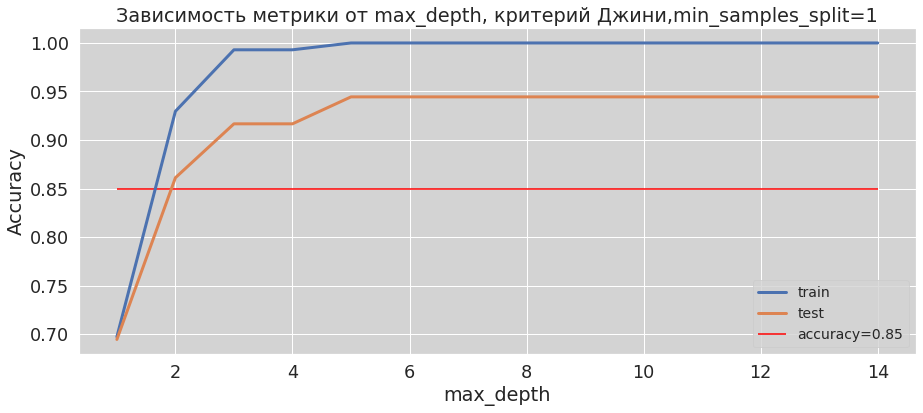

In [26]:
plot_dependence('max_depth', range(1, 15), 
                title='Зависимость метрики от max_depth, критерий Джини,min_samples_split=1', criterion=gini_criterion,min_samples_split=1)

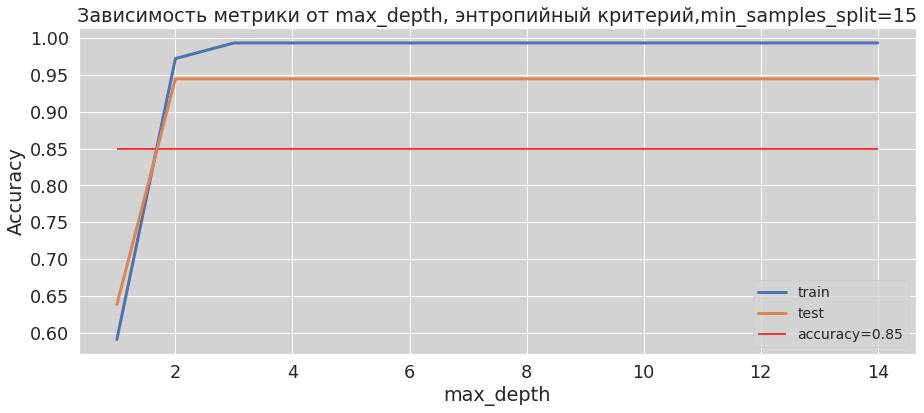

In [27]:
plot_dependence('max_depth', range(1, 15), 
                title='Зависимость метрики от max_depth, энтропийный критерий,min_samples_split=15', criterion=entropy_criterion,min_samples_split=15)

Сделайте выводы. Почему графики получились такими? Как соотносятся оптимальные значения параметров на обучающей и на тестовой выборках?

**Вывод.**

По умолчанию уже в реализованном алгоритме по умолчанию глубина 3, так что мы изначально ожидали, что у нас оптимальная глубина будет 2-4. Мы перебрали с помощью gridsearch параметры нашей реализации дерева. В случае критерия Джини оптимальными являются глубина 4, а min_samples_split=1. В случае энтропийного критерия уже оптимальными являются min_samples_split=15 и глубина равная 3. Также хотелось бы заметить, что с ростом глубины train не убывает, это объяснется тем, что с ростом глубины мы можем более точно построить дерево. Также хотел бы обратить внимание на первый график, на нем видно, что оптимальный результат достигается не на глубине 4, а на глубине 5. Но это связано с тем, что у не очень много данных и gridseacrh слегка не точно выдал результат. Также при достаточно большой глубине результат метрики на train ~1, это связано с тем, что мы очень глубоко и подробно строим дерево для train данных

**2. Задача регрессии.**

Проделайте аналогичные шаги для задачи регрессии. В качестве датасете возьмите `boston` из `sklearn`, а в качестве критерия качества возьмите r2_score. Рассмотрим диапозон значений для `max_depth`: от 3 до 14.

In [8]:
from sklearn.datasets import load_boston

boston_X, boston_y = load_boston(return_X_y=True)

In [9]:
regression_criteria = [mean_square_criterion,mean_abs_criterion]
criterion_names = ["Критерий для квадратичной функции потерь","Критерий для абсолютной функции потерь"]

Разобьём выборку на обучение и тест.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(boston_X, boston_y, test_size=0.2,random_state=1)

Проведите эксперименты, аналогичны тем, что были сделаны для задачи классификации.

In [12]:
for criterion, criterion_name in zip(regression_criteria, criterion_names):    
    tree_gridsearch = GridSearchCV(
    estimator=DecisionTreeRegressor(criterion=criterion),
    scoring='r2',
    n_jobs=-1,
    param_grid={'max_depth': np.arange(3, 15), 
                'min_samples_split': [1, 2, 5, 10,15,20,25,30,35,40]},
    verbose=1
)
    
    tree_gridsearch.fit(X_train, y_train)
    print("Результаты с использованием",criterion_name)
    print(tree_gridsearch.best_params_)
    print('train r2_score {:.4f}'.format(r2_score(tree_gridsearch.best_estimator_.predict(X_train), y_train)))
    print('test r2_score {:.4f}'.format(r2_score(tree_gridsearch.best_estimator_.predict(X_test), y_test)))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Результаты с использованием Критерий для квадратичной функции потерь
{'max_depth': 6, 'min_samples_split': 10}
train r2_score 0.9308
test r2_score 0.8123
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Результаты с использованием Критерий для абсолютной функции потерь
{'max_depth': 12, 'min_samples_split': 30}
train r2_score 0.8559
test r2_score 0.7286


In [13]:
def get_train_and_test_r2_score(param_name, grid, criterion=mean_square_criterion, min_samples_split=2):
    '''
    Функция для оценки точности классификации 
    для заданных значений параметра param_name
    
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра
    '''
        
    train_acc, test_acc = [], []
    
    for param_value in grid:
        estimator = DecisionTreeRegressor(**{param_name: param_value},min_samples_split=min_samples_split,criterion=criterion)
        estimator.fit(X_train, y_train)
        train_acc.append(r2_score(y_train, estimator.predict(X_train)))
        test_acc.append(r2_score(y_test, estimator.predict(X_test)))
    return train_acc, test_acc
def plot_dependence(param_name, grid=range(2, 20), title='',criterion=gini_criterion, min_samples_split=2):
    '''
    Функция для отображения графика зависимости accuracy 
    от значения параметра c названием param_name
    
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра,
    3) title - заголовок графика
    '''
    
    plt.figure(figsize=(15, 6))
    
    train_acc, test_acc = get_train_and_test_r2_score(param_name, grid,criterion, min_samples_split)
        
    plt.plot(grid, train_acc, label='train', lw=3)
    plt.plot(grid, test_acc, label='test', lw=3)
    plt.xlabel(param_name)
    plt.ylabel('r2_score')
    plt.title(title)
    plt.legend(fontsize=14)
    plt.show()

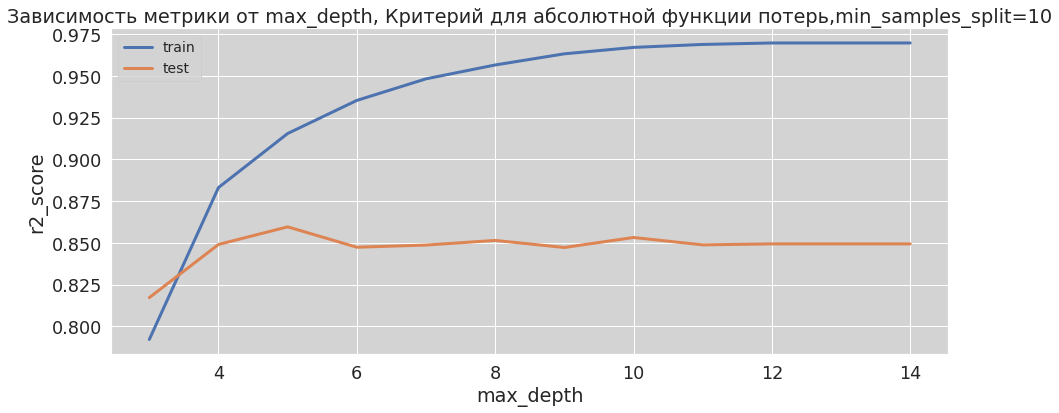

In [14]:
plot_dependence('max_depth', range(3, 15), 
                title='Зависимость метрики от max_depth, Критерий для абсолютной функции потерь,min_samples_split=10',
                criterion=mean_square_criterion,min_samples_split=10)

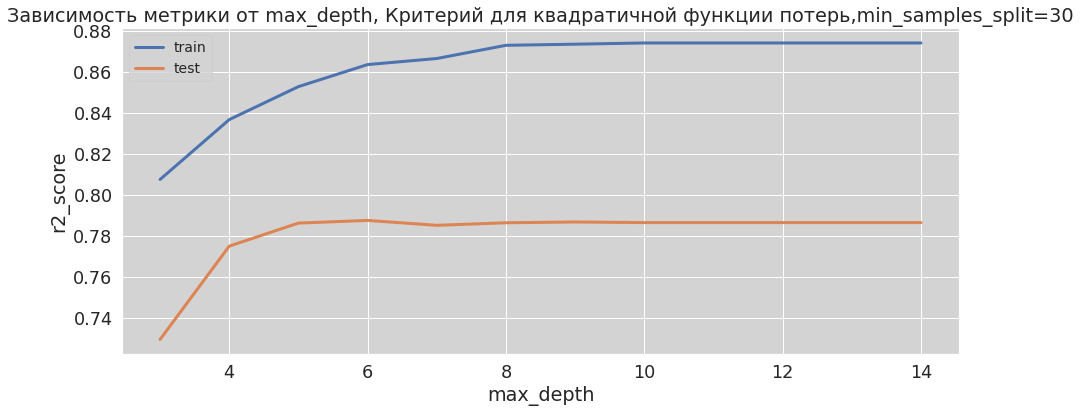

In [15]:
plot_dependence('max_depth', range(3, 15), 
                title='Зависимость метрики от max_depth, Критерий для квадратичной функции потерь,min_samples_split=30',
                criterion=mean_abs_criterion,min_samples_split=30)

Сделайте вывод, в котором объясните, почему графики получились такими.

Скорее всего, вы заметили, что дерево в этих экспериментах строится довольно медленно. Как можно ускорить его построение? Можно ли ускорить нахождение оптимального разбиения по некоторому вещественному признаку?

**Вывод.**

Давайте для начала скажем, как можно ускорить его построение и ускорить оптимальное разбиение. На самом деле самый долгий процесс это цикл в цикле, где мы перебираем все признаки и пороговые значения. Но на самом деле нам нужны пороговые значения только тех элементов, которые сейчас в узле дерева, так как наша цель поделить на левое и правое поддерево или же сделать его листом. Также мы для пары (признак, пороговое значение) перебираем все элементы в нашем узле, но если мы их отсортируем, то нам нужно будет проверить только такие значения, которые близки к балансу между левым и правым сыном. То есть в каждой вершине будем хранить уже отсортированный массив значений, а потом нужный элемент можно будет искать бинарным поиском. А еще мне кажется, что можно деревья написать на плюсах, так как тогда они будут немного быстрее работать) и всегда можно алгоритм реализовать без рекурсии, придется помучаться со стеком, но скорость работы увеличится значительно.

Теперь давайте посмотрим на полученные графики. На первом графике видно, что лучшая метрика при глубине 5, затем видно, что моделька немного переучивается. Но $R^2$ около 0.85, что очень хорошо. На втором же графике у нас $R^2$ 0.79, что тоже довольно хорошо. Но уже незаметно такое заметное переобучение. Также видно, что на глубине 5 дерево для решения регрессии достигает уже хороших результатов, а дальше начинает слегка переобучаться.

## Задача 4.

В этой задаче вам предстоит освоиться с обработкой пропусков в решающих деревьях, реализованной ранее.

Рассмотрим датасет, в котором часть данных пропущена. В качестве примера возьмём датасет https://archive.ics.uci.edu/ml/datasets/Adult для определения категории дохода работников, по таким признакам, как возраст, образование, специальность, класс работы, пол, кол-во отрабатываемых часов в неделю и некоторым другим.

In [ ]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education1', 'education2', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain',
    'capital-loss', 'hours-per-week', 'native-country', 'target'
]

Поскольку предсказание в дереве на данных с пропусками часто занимает сильно больше времени, чем в случае отсутствия пропусков (так как часто приходится спускаться разу в 2 поддерева), то для экономии времени сократим датасет, взяв из него только первые 10000 строк данных.

In [ ]:
adult_df = pd.read_csv('../input/adultdata/adult.data', header=None)[:10000]
adult_df.columns = column_names
target = adult_df['target'] == ' >50K'
adult_df = adult_df.drop(['target'], axis=1)
adult_df.head()

,age,workclass,fnlwgt,education1,education2,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


Предобработаем датасет, заменив категориальные признаки one-hot векторами.

In [ ]:
adult_df = pd.get_dummies(adult_df)
adult_df.head()

,age,fnlwgt,education2,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Поскольку все пропущенные значения относились к категориальным признакам и помечались в датасете знаком `?`, то для каждого категориального признака `feature` исходного датасета надо выполнить следующую процедуру: рассмотреть признак `feature_?` нового датасета и для всех строк, для которых выполнено `feature_?=1`, значениях всех признаков с префиксом `feature` установить в `None`. 

In [ ]:
all_indices = np.arange(adult_df.shape[0])

for feature in column_names:
    if f'{feature}_ ?' in adult_df.columns:
        none_indices = all_indices[adult_df[f'{feature}_ ?'] == 1]
        
        for dummy_feature in adult_df.columns:
            if not dummy_feature.startswith(f'{feature}_ '):
                continue
            if dummy_feature != f'{feature}_ ?':
                adult_df[dummy_feature][none_indices] = None
        adult_df = adult_df.drop(f'{feature}_ ?', axis=1)

Посмотрим на распределение пропущенных значений по признакам.

In [ ]:
np.sum(adult_df.isnull(), axis=0)

age                                  0
fnlwgt                               0
education2                           0
capital-gain                         0
capital-loss                         0
                                  ... 
native-country_ Thailand           181
native-country_ Trinadad&Tobago    181
native-country_ United-States      181
native-country_ Vietnam            181
native-country_ Yugoslavia         181
Length: 104, dtype: int64

Разобьём данные на обучающую и тестовую выборки в отношении 3:1.

In [ ]:
X_adult_train, X_adult_test, y_adult_train, y_adult_test = train_test_split(
    adult_df, target, random_state=777
)

In [ ]:
X_adult_train=np.array(X_adult_train)
X_adult_test=np.array(X_adult_test)
y_adult_train=np.array(y_adult_train)*1
y_adult_test=np.array(y_adult_test)*1

При помощи кросс-валидации найдём оптимальные гиперпараметры для каждого из критериев разбиения деревьев для классификации.

In [ ]:
np.unique(y_adult_train,return_counts=True)#довольно большое отличие между ними

(array([0, 1]), array([5720, 1780]))

In [ ]:
classification_criteria = [gini_criterion,entropy_criterion]
criterion_names = ["Критерий Джини","Энтропийный критерий"]

In [ ]:
#давайте будем использовать scoring=make_scorer(f1_score, average='macro')
for criterion, criterion_name in zip(classification_criteria, criterion_names):    
    tree_gridsearch = GridSearchCV(
    estimator=DecisionTreeClassifier(criterion=criterion),
    scoring=make_scorer(f1_score, average='macro'),
    n_jobs=-1,
    param_grid={'max_depth': np.arange(3, 11), 
                'min_samples_split': [1, 2, 5,50,100,250,500,1000]},
    verbose=1
)
    
    tree_gridsearch.fit(X_adult_train, y_adult_train)
    print(tree_gridsearch.best_params_)
    accuracy = accuracy_score(tree_gridsearch.best_estimator_.predict(X_adult_test), y_adult_test)
    print('accuracy:',criterion_name, accuracy)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 54.1min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 131.6min finished


{'max_depth': 6, 'min_samples_split': 5}
accuracy: Критерий Джини 0.8496
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 54.7min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 133.8min finished


{'max_depth': 7, 'min_samples_split': 100}
accuracy: Энтропийный критерий 0.8492


Теперь давайте попробуем с scoring=make_scorer(f1_score, average='micro'), так как у нас все же наблюдается некоторый дисбаланс в y_adult_train

In [ ]:
#давайте будем использовать scoring=make_scorer(f1_score, average='micro')
for criterion, criterion_name in zip(classification_criteria, criterion_names):    
    tree_gridsearch = GridSearchCV(
    estimator=DecisionTreeClassifier(criterion=criterion),
    scoring=make_scorer(f1_score, average='micro'),
    n_jobs=-1,
    param_grid={'max_depth': np.arange(3, 11), 
                'min_samples_split': [1, 2, 5, 10,50,100,250,500,1000]},
    verbose=1
)
    
    tree_gridsearch.fit(X_adult_train, y_adult_train)
    print(tree_gridsearch.best_params_)
    accuracy = accuracy_score(tree_gridsearch.best_estimator_.predict(X_adult_test), y_adult_test)
    print('accuracy:',criterion_name, accuracy)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 51.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 148.0min finished


{'max_depth': 8, 'min_samples_split': 5}
accuracy: Критерий Джини 0.8472
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 153.3min finished


{'max_depth': 8, 'min_samples_split': 100}
accuracy: Энтропийный критерий 0.85


In [ ]:
for criterion, criterion_name in zip(classification_criteria, criterion_names):    
    tree_gridsearch = GridSearchCV(
    estimator=DecisionTreeClassifier(criterion=criterion),
    scoring='accuracy',
    n_jobs=-1,
    param_grid={'max_depth': np.arange(3, 11), 
                'min_samples_split': [1, 2, 5, 10,50,100,250,500,1000]},
    verbose=1
)
    
    tree_gridsearch.fit(X_adult_train, y_adult_train)
    print(tree_gridsearch.best_params_)
    accuracy = accuracy_score(tree_gridsearch.best_estimator_.predict(X_adult_test), y_adult_test)
    print('accuracy:',criterion_name, accuracy)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 125.4min finished


{'max_depth': 8, 'min_samples_split': 5}
accuracy: Критерий Джини 0.8472
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 126.1min finished


{'max_depth': 8, 'min_samples_split': 100}
accuracy: Энтропийный критерий 0.85


Тут я ради интереса попробовал запустить gridsearch с разными scoring, f1_micro, f1_macro,accuracy. Так как тут наблюдается довольно большой дисбаланс у таргета, поэтому могли быть проблемы у какого-то метрики. Но разница между f1_micro,f1_macro почти незаметна в итоге.

Проведите эксперименты c построением графиков, аналогичные тем, что были сделаны в предыдущем пункте для задач классификации и регрессии.

In [ ]:
def get_train_and_test_accuracy(param_name, grid, criterion=gini_criterion, min_samples_split=2):
    '''
    Функция для оценки точности классификации 
    для заданных значений параметра param_name
    
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра
    '''
        
    train_acc, test_acc = [], []
    
    for param_value in grid:
        estimator = DecisionTreeClassifier(**{param_name: param_value},min_samples_split=min_samples_split,criterion=criterion)
        estimator.fit(X_adult_train, y_adult_train)
        train_acc.append(accuracy_score(y_adult_train, estimator.predict(X_adult_train)))
        test_acc.append(accuracy_score(y_adult_test, estimator.predict(X_adult_test)))
    return train_acc, test_acc
def plot_dependence(param_name, grid=range(2, 20), title='',criterion=gini_criterion, min_samples_split=2):
    '''
    Функция для отображения графика зависимости accuracy 
    от значения параметра c названием param_name
    
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра,
    3) title - заголовок графика
    '''
    
    plt.figure(figsize=(15, 6))
    
    train_acc, test_acc = get_train_and_test_accuracy(param_name, grid,criterion, min_samples_split)
        
    plt.plot(grid, train_acc, label='train', lw=3)
    plt.plot(grid, test_acc, label='test', lw=3)
    plt.xlabel(param_name)
    plt.ylabel('Аccuracy')
    plt.title(title)
    plt.hlines(0.85,min(grid),max(grid),colors='red',label='accuracy=0.85')
    plt.legend(fontsize=14)
    plt.show()

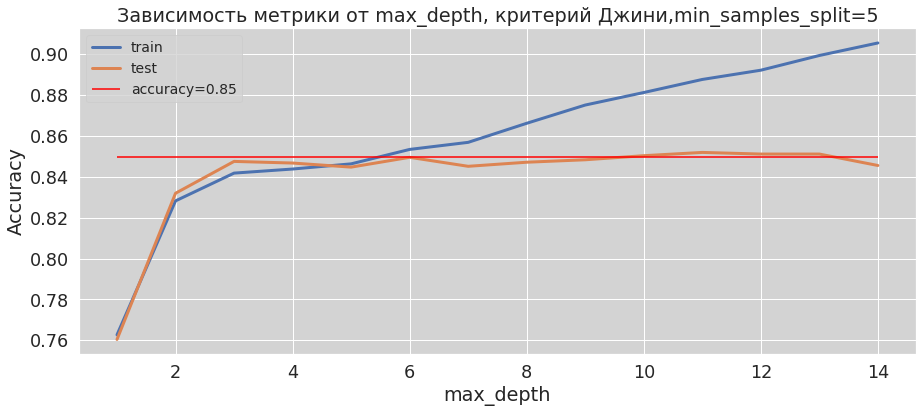

In [ ]:
plot_dependence('max_depth', range(1, 15), 
                title='Зависимость метрики от max_depth, критерий Джини,min_samples_split=5', criterion=gini_criterion,min_samples_split=5)

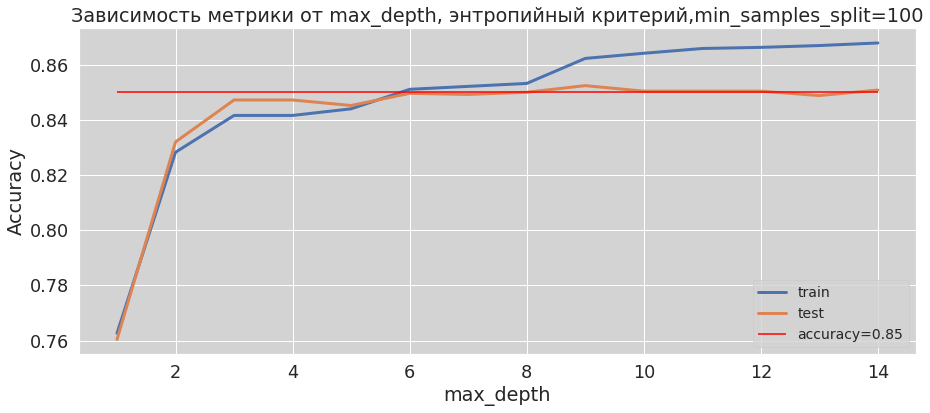

In [ ]:
plot_dependence('max_depth', range(1, 15), 
                title='Зависимость метрики от max_depth, энтропийный критерий,min_samples_split=100', criterion=entropy_criterion,min_samples_split=100)

**Вывод.**
Как хорошо видно, мы все же достигаем accuracy=0.85, хоть и на грани. Также видно, что оптимальная глубина увеличилась, на двух графиках она около 8. Что довольно логично, так как у нас довольно много тут данных и признаков было. Также видно, что при max_depth около 15, у нас все равно наблюдается переобучение. Также для разных критериев (энтропийный и Джини оптимальный параметр min_samples_split разные). Также было заметно, что процесс построения дерева занимал очень много времени, так как еще в пред. номерах мы отмечали довольно большое время выполнения, а тут у нас уже вместо 100, было 10000 данных